# SSBH Dataset Preprocessing

This notebook preprocesses the SSBH (Sentinel-1 Sentinel-2 based Building Height) dataset to extract:
- **RGB imagery** from Sentinel-2 bands (B4-red, B3-green, B2-blue)
- **Building height annotations** from height rasters
- **Building masks** generated from height data using thresholds

The processed data will be organized in the `preprocessed` folder with subdirectories:
- `rgb/` - RGB composite images
- `height/` - Building height rasters  
- `mask/` - Binary building masks

**Dataset Coverage:** 67 cuts with multiple tiles per cut (256×256 pixels, 10m resolution)

## 1. Setup Environment and Imports

Import necessary libraries for geospatial data processing, file handling, and visualization.

In [118]:
import rasterio
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
from typing import List, Tuple, Optional
import shutil
from scipy.ndimage import binary_opening, binary_closing
from scipy.interpolate import griddata
from scipy.ndimage import distance_transform_edt
import cv2

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Rasterio version: {rasterio.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Rasterio version: 1.4.3
NumPy version: 2.0.2


## 2. Define Dataset Paths and Configuration

Set up paths, parameters, and configuration for the preprocessing pipeline.

In [ ]:
# Dataset configuration
BASE_PATH = Path(".")  # Current directory - assumes raw/ folder is in same directory as this notebook
OUTPUT_PATH = BASE_PATH / "preprocessed"

# Range of cuts to process
CUTS_RANGE = range(1, 68)  # Cuts 1 to 67

# Building mask configuration
HEIGHT_THRESHOLD = 0  # 1.5  # meters - pixels above this height are considered buildings
MIN_BUILDING_SIZE = 1   # minimum number of pixels for a building (noise reduction)

# Band information (based on README)
SENTINEL2_BANDS = {
    'b2': 'blue',   # 490nm - Blue
    'b3': 'green',  # 560nm - Green  
    'b4': 'red',    # 665nm - Red
    'b8': 'nir'     # 842nm - Near Infrared
}

# Reflectance scaling factor (from README: scaled by 10,000)
S2_SCALE_FACTOR = 10000.0

print(f"Base dataset path: {BASE_PATH.resolve()}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Processing cuts: {CUTS_RANGE.start} to {CUTS_RANGE.stop - 1}")
print(f"Height threshold for buildings: {HEIGHT_THRESHOLD}m")
print(f"Minimum building size: {MIN_BUILDING_SIZE} pixels")

Base dataset path: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH
Output path: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_preprocessed
Processing cuts: 1 to 67
Height threshold for buildings: 0m
Minimum building size: 1 pixels


## 3. Create Output Directory Structure

Create the necessary directories for organizing preprocessed data.

In [120]:
def create_output_directories():
    """Create the output directory structure for preprocessed data."""
    directories = [
        OUTPUT_PATH / "rgb",
        OUTPUT_PATH / "height", 
        OUTPUT_PATH / "mask"
    ]
    
    for directory in directories:
        directory.mkdir(parents=True, exist_ok=True)
        print(f"Created directory: {directory}")
    
    return directories

# Create output directories
output_dirs = create_output_directories()
print("\nOutput directory structure created successfully!")

Created directory: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_preprocessed\rgb
Created directory: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_preprocessed\height
Created directory: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_preprocessed\mask

Output directory structure created successfully!


## 4. Load and Process Sentinel-2 Bands for RGB

Functions to read and combine Sentinel-2 bands into RGB imagery.

In [ ]:
def read_raster_band(file_path: Path) -> np.ndarray:
    """Read a single raster band and return as numpy array."""
    try:
        with rasterio.open(file_path) as src:
            return src.read(1).astype(np.float32)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def create_rgb_composite(cut_num: int, tile_id: str) -> Optional[np.ndarray]:
    """
    Create RGB composite from Sentinel-2 bands B4(Red), B3(Green), B2(Blue).
    
    Args:
        cut_num: Cut number (1-67)
        tile_id: Tile identifier (e.g., '0001')
    
    Returns:
        RGB array with shape (height, width, 3) or None if files missing
    """
    cut_path = BASE_PATH / "raw" / f"cut{cut_num}"
    
    # Define band file paths
    band_paths = {
        'red': cut_path / f"sentinel2_AREA_b4" / f"{tile_id}_b4.tif",    # B4 - Red
        'green': cut_path / f"sentinel2_AREA_b3" / f"{tile_id}_b3.tif",  # B3 - Green  
        'blue': cut_path / f"sentinel2_AREA_b2" / f"{tile_id}_b2.tif"    # B2 - Blue
    }
    
    # Check if all band files exist
    missing_files = [path for path in band_paths.values() if not path.exists()]
    if missing_files:
        return None
    
    # Read bands
    bands = {}
    for color, path in band_paths.items():
        band_data = read_raster_band(path)
        if band_data is None:
            return None
        bands[color] = band_data
    
    # Stack bands into RGB array (H, W, 3)
    rgb_array = np.stack([bands['red'], bands['green'], bands['blue']], axis=-1)
    
    # Apply scaling and normalization
    # Scale from integer (0-10000) to float (0-1) for reflectance
    rgb_array = rgb_array / S2_SCALE_FACTOR
    
    # Clip values to [0, 1] range
    rgb_array = np.clip(rgb_array, 0, 1)
    
    return rgb_array

def enhance_rgb_contrast(rgb_array: np.ndarray, percentile_stretch: Tuple[float, float] = (2, 98)) -> np.ndarray:
    """
    Enhance RGB contrast using percentile stretching.
    
    Args:
        rgb_array: RGB array with values in [0, 1]
        percentile_stretch: Lower and upper percentiles for stretching
    
    Returns:
        Enhanced RGB array
    """
    enhanced = rgb_array.copy()
    
    for i in range(3):  # For each channel
        channel = enhanced[:, :, i]
        # Calculate percentiles
        p_low, p_high = np.percentile(channel[channel > 0], percentile_stretch)
        # Stretch values
        channel = np.clip((channel - p_low) / (p_high - p_low), 0, 1)
        enhanced[:, :, i] = channel
    
    return enhanced

# Test RGB creation with a sample tile
print("RGB processing functions defined successfully!")
print("Testing with a sample tile...")

RGB processing functions defined successfully!
Testing with a sample tile...


## 5. Extract Building Height Data

Functions to read and process building height rasters.

In [122]:
def read_height_data(cut_num: int, tile_id: str, use_interpolation: bool = True) -> Optional[np.ndarray]:
    """
    Read building height data from _bhr folder with improved handling of invalid values.
    
    Args:
        cut_num: Cut number (1-67)
        tile_id: Tile identifier (e.g., '0001')
        use_interpolation: Whether to interpolate invalid values instead of setting to 0
    
    Returns:
        Height array or None if file missing
    """
    cut_path = BASE_PATH / "raw" / f"cut{cut_num}"
    height_path = cut_path / "_bhr" / f"{tile_id}.tif"
    
    if not height_path.exists():
        return None
    
    try:
        with rasterio.open(height_path) as src:
            height_data = src.read(1).astype(np.float32)
            
            # Create mask for invalid values
            invalid_mask = np.zeros_like(height_data, dtype=bool)
            
            # Handle nodata values
            if src.nodata is not None:
                invalid_mask |= (height_data == src.nodata)
            
            # Handle NaN values
            invalid_mask |= np.isnan(height_data)
            
            # Handle negative heights
            invalid_mask |= (height_data < 0)
            
            if use_interpolation and np.any(invalid_mask):
                # Interpolate invalid values using nearby valid pixels
                height_data = interpolate_invalid_heights(height_data, invalid_mask)
            else:
                # Simple approach: set invalid values to 0
                height_data[invalid_mask] = 0
            
            # Final safety check: ensure non-negative heights
            height_data = np.maximum(height_data, 0)
            
            return height_data
            
    except Exception as e:
        print(f"Error reading height data from {height_path}: {e}")
        return None

def interpolate_invalid_heights(height_data: np.ndarray, invalid_mask: np.ndarray) -> np.ndarray:
    """
    Interpolate invalid height values using nearby valid pixels.
    
    Args:
        height_data: Original height data array
        invalid_mask: Boolean mask indicating invalid pixels
    
    Returns:
        Height array with interpolated values
    """
    from scipy.ndimage import distance_transform_edt
    from scipy.interpolate import griddata
    
    # Make a copy to avoid modifying original
    interpolated_data = height_data.copy()
    
    # Get valid data points
    valid_mask = ~invalid_mask
    
    if not np.any(valid_mask):
        # No valid data available, set everything to 0
        return np.zeros_like(height_data)
    
    # Method 1: Simple nearest neighbor interpolation for small gaps
    if np.sum(invalid_mask) / invalid_mask.size < 0.1:  # Less than 10% invalid
        # Use distance transform for nearest neighbor interpolation
        indices = distance_transform_edt(invalid_mask, return_distances=False, return_indices=True)
        interpolated_data[invalid_mask] = height_data[tuple(indices[:, invalid_mask])]
    
    else:
        # Method 2: Griddata interpolation for larger gaps
        try:
            # Get coordinates of valid and invalid points
            rows, cols = np.meshgrid(np.arange(height_data.shape[0]), 
                                   np.arange(height_data.shape[1]), indexing='ij')
            
            # Valid points for interpolation
            valid_points = np.column_stack((rows[valid_mask], cols[valid_mask]))
            valid_values = height_data[valid_mask]
            
            # Invalid points to interpolate
            invalid_points = np.column_stack((rows[invalid_mask], cols[invalid_mask]))
            
            # Perform interpolation (using 'nearest' to avoid extrapolation issues)
            interpolated_values = griddata(valid_points, valid_values, invalid_points, 
                                         method='nearest', fill_value=0.0)
            
            # Fill in the interpolated values
            interpolated_data[invalid_mask] = interpolated_values
            
        except Exception as e:
            print(f"Warning: Interpolation failed, using nearest neighbor fallback: {e}")
            # Fallback to simple nearest neighbor
            indices = distance_transform_edt(invalid_mask, return_distances=False, return_indices=True)
            interpolated_data[invalid_mask] = height_data[tuple(indices[:, invalid_mask])]
    
    return interpolated_data

def validate_height_data(height_array: np.ndarray) -> dict:
    """
    Validate and analyze height data.
    
    Args:
        height_array: Height data array
    
    Returns:
        Dictionary with statistics
    """
    stats = {
        'min_height': float(np.min(height_array)),
        'max_height': float(np.max(height_array)),
        'mean_height': float(np.mean(height_array)),
        'building_pixels': int(np.sum(height_array > 0)),
        'total_pixels': int(height_array.size),
        'building_coverage': float(np.sum(height_array > 0) / height_array.size)
    }
    
    return stats

print("Height processing functions defined successfully!")

Height processing functions defined successfully!


## 6. Generate Building Masks from Height Data

Functions to create binary building masks using height thresholds.

In [123]:
def create_building_mask(height_array: np.ndarray, 
                        height_threshold: float = HEIGHT_THRESHOLD,
                        min_size: int = MIN_BUILDING_SIZE,
                        apply_morphology: bool = False) -> np.ndarray:
    """
    Create building mask from height data.
    
    Note: apply_morphology=False (None) is preferred based on visual analysis
    showing better alignment with RGB imagery and height data.
    
    Parameters:
    -----------
    height_array: Height data array
    height_threshold: Minimum height to consider as building (meters)
    min_size: Minimum building size in pixels (noise reduction)
    apply_morphology: Whether to apply morphological operations
    
    Returns:
    --------
    Binary building mask array
    """
    # Create initial binary mask
    mask = (height_array > height_threshold).astype(np.uint8)
    
    if apply_morphology:
        # Apply morphological operations to reduce noise
        # Opening: removes small objects (noise)
        kernel = np.ones((2, 2), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        # Closing: fills small holes
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Remove small connected components (noise reduction)
    if min_size > 1:
        # Find connected components
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        
        # Keep only components larger than min_size
        mask_filtered = np.zeros_like(mask)
        for i in range(1, num_labels):  # Skip background (label 0)
            if stats[i, cv2.CC_STAT_AREA] >= min_size:
                mask_filtered[labels == i] = 1
        
        mask = mask_filtered
    
    return mask

def analyze_mask_statistics(mask: np.ndarray) -> dict:
    """
    Analyze building mask statistics.
    
    Args:
        mask: Binary building mask
    
    Returns:
        Dictionary with mask statistics
    """
    total_pixels = mask.size
    building_pixels = np.sum(mask)
    
    # Find connected components for building count
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(mask.astype(np.uint8), connectivity=8)
    building_count = num_labels - 1  # Subtract background
    
    # Calculate building sizes
    building_sizes = stats[1:, cv2.CC_STAT_AREA] if building_count > 0 else []
    
    stats_dict = {
        'total_pixels': int(total_pixels),
        'building_pixels': int(building_pixels),
        'building_coverage': float(building_pixels / total_pixels),
        'building_count': int(building_count),
        'avg_building_size': float(np.mean(building_sizes)) if len(building_sizes) > 0 else 0,
        'max_building_size': int(np.max(building_sizes)) if len(building_sizes) > 0 else 0,
        'min_building_size': int(np.min(building_sizes)) if len(building_sizes) > 0 else 0
    }
    
    return stats_dict

print("Building mask generation functions defined successfully!")

Building mask generation functions defined successfully!


## 7. Process All Dataset Cuts (1-67)

Main processing pipeline to extract and save RGB, height, and mask data.

In [124]:
def get_tile_ids(cut_num: int) -> List[str]:
    """
    Get list of available tile IDs for a given cut.
    
    Args:
        cut_num: Cut number (1-67)
    
    Returns:
        List of tile IDs (e.g., ['0001', '0002', ...])
    """
    cut_path = BASE_PATH / f"cut{cut_num}"
    height_path = cut_path / "_bhr"
    
    if not height_path.exists():
        return []
    
    tile_ids = []
    for tif_file in height_path.glob("*.tif"):
        tile_id = tif_file.stem  # Remove .tif extension
        tile_ids.append(tile_id)
    
    return sorted(tile_ids)

def save_rgb_image(rgb_array: np.ndarray, output_path: Path, 
                  metadata: dict = None) -> bool:
    """
    Save RGB array as GeoTIFF with 3 bands.
    
    Args:
        rgb_array: RGB array with shape (H, W, 3)
        output_path: Output file path
        metadata: Optional metadata dictionary
    
    Returns:
        True if successful, False otherwise
    """
    try:
        height, width = rgb_array.shape[:2]
        
        # Convert to uint16 for better storage (0-65535 range)
        rgb_uint16 = (rgb_array * 65535).astype(np.uint16)
        
        # Rearrange from (H, W, 3) to (3, H, W) for rasterio
        rgb_bands = np.transpose(rgb_uint16, (2, 0, 1))
        
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=3,
            dtype=np.uint16,
            compress='lzw'
        ) as dst:
            dst.write(rgb_bands)
            if metadata:
                dst.update_tags(**metadata)
        
        return True
    
    except Exception as e:
        print(f"Error saving RGB image to {output_path}: {e}")
        return False

def save_single_band(array: np.ndarray, output_path: Path, 
                    dtype: np.dtype = np.float32, nodata: float = None) -> bool:
    """
    Save single-band array as GeoTIFF.
    
    Args:
        array: 2D array to save
        output_path: Output file path
        dtype: Data type for output
        nodata: No-data value
    
    Returns:
        True if successful, False otherwise
    """
    try:
        height, width = array.shape
        
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=dtype,
            compress='lzw',
            nodata=nodata
        ) as dst:
            dst.write(array.astype(dtype), 1)
        
        return True
    
    except Exception as e:
        print(f"Error saving array to {output_path}: {e}")
        return False

def process_single_tile(cut_num: int, tile_id: str) -> dict:
    """
    Process a single tile: extract RGB, height, and mask.
    
    Args:
        cut_num: Cut number
        tile_id: Tile identifier
    
    Returns:
        Dictionary with processing results
    """
    result = {
        'cut': cut_num,
        'tile': tile_id,
        'rgb_success': False,
        'height_success': False,
        'mask_success': False,
        'error': None
    }
    
    try:
        # Create output file names (consistent naming without modality suffixes)
        rgb_output = OUTPUT_PATH / "rgb" / f"cut{cut_num:02d}_{tile_id}.tif"
        height_output = OUTPUT_PATH / "height" / f"cut{cut_num:02d}_{tile_id}.tif"
        mask_output = OUTPUT_PATH / "mask" / f"cut{cut_num:02d}_{tile_id}.tif"
        
        # 1. Process RGB
        rgb_array = create_rgb_composite(cut_num, tile_id)
        if rgb_array is not None:
            # Apply contrast enhancement
            rgb_enhanced = enhance_rgb_contrast(rgb_array)
            metadata = {'source': f'cut{cut_num}_tile{tile_id}', 'bands': 'RGB_B4B3B2'}
            result['rgb_success'] = save_rgb_image(rgb_enhanced, rgb_output, metadata)
        
        # 2. Process Height
        height_array = read_height_data(cut_num, tile_id)
        if height_array is not None:
            result['height_success'] = save_single_band(height_array, height_output, 
                                                       dtype=np.float32, nodata=-9999)
            
            # 3. Process Mask (derived from height)
            mask_array = create_building_mask(height_array)
            result['mask_success'] = save_single_band(mask_array, mask_output, 
                                                     dtype=np.uint8, nodata=255)
        
    except Exception as e:
        result['error'] = str(e)
    
    return result

print("Processing functions defined successfully!")

Processing functions defined successfully!


In [125]:
# Main processing pipeline
def process_all_cuts():
    """Process all cuts in the dataset."""
    
    total_tiles_processed = 0
    total_rgb_success = 0
    total_height_success = 0
    total_mask_success = 0
    processing_log = []
    
    print(f"Starting processing of {len(CUTS_RANGE)} cuts...")
    print(f"Height threshold: {HEIGHT_THRESHOLD}m")
    print(f"Minimum building size: {MIN_BUILDING_SIZE} pixels")
    print("-" * 60)
    
    # Process each cut
    for cut_num in tqdm(CUTS_RANGE, desc="Processing cuts"):
        tile_ids = get_tile_ids(cut_num)
        
        if not tile_ids:
            print(f"Warning: No tiles found for cut{cut_num}")
            continue
        
        cut_rgb_success = 0
        cut_height_success = 0
        cut_mask_success = 0
        
        # Process each tile in the cut
        for tile_id in tqdm(tile_ids, desc=f"Cut {cut_num} tiles", leave=False):
            result = process_single_tile(cut_num, tile_id)
            
            # Update counters
            total_tiles_processed += 1
            if result['rgb_success']:
                total_rgb_success += 1
                cut_rgb_success += 1
            if result['height_success']:
                total_height_success += 1
                cut_height_success += 1
            if result['mask_success']:
                total_mask_success += 1
                cut_mask_success += 1
            
            # Log any errors
            if result['error']:
                processing_log.append(f"Cut {cut_num}, Tile {tile_id}: {result['error']}")
        
        # Print cut summary
        print(f"Cut {cut_num:2d}: {len(tile_ids):2d} tiles | "
              f"RGB: {cut_rgb_success:2d}/{len(tile_ids)} | "
              f"Height: {cut_height_success:2d}/{len(tile_ids)} | "
              f"Mask: {cut_mask_success:2d}/{len(tile_ids)}")
    
    # Print final summary
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total tiles processed: {total_tiles_processed}")
    print(f"RGB composites created: {total_rgb_success} ({total_rgb_success/total_tiles_processed*100:.1f}%)")
    print(f"Height rasters copied: {total_height_success} ({total_height_success/total_tiles_processed*100:.1f}%)")
    print(f"Building masks created: {total_mask_success} ({total_mask_success/total_tiles_processed*100:.1f}%)")
    
    if processing_log:
        print(f"\nErrors encountered: {len(processing_log)}")
        for error in processing_log[:10]:  # Show first 10 errors
            print(f"  - {error}")
        if len(processing_log) > 10:
            print(f"  ... and {len(processing_log) - 10} more errors")
    
    return {
        'total_tiles': total_tiles_processed,
        'rgb_success': total_rgb_success,
        'height_success': total_height_success,
        'mask_success': total_mask_success,
        'errors': processing_log
    }

# Run the processing (uncomment to execute)
# processing_results = process_all_cuts()

print("Main processing pipeline ready!")
print("Uncomment the last line to start processing all cuts.")

Main processing pipeline ready!
Uncomment the last line to start processing all cuts.


## 8. Verify Preprocessed Data

Functions to validate and visualize the preprocessed data.

In [126]:
def load_preprocessed_sample(sample_name: str) -> dict:
    """
    Load a sample of preprocessed data for visualization.
    
    Args:
        sample_name: Sample identifier (e.g., 'cut01_0001')
    
    Returns:
        Dictionary with loaded data
    """
    # Define file paths (consistent naming without modality suffixes)
    rgb_path = OUTPUT_PATH / "rgb" / f"{sample_name}.tif"
    height_path = OUTPUT_PATH / "height" / f"{sample_name}.tif"
    mask_path = OUTPUT_PATH / "mask" / f"{sample_name}.tif"
    
    result = {'sample_name': sample_name}
    
    # Load RGB
    if rgb_path.exists():
        with rasterio.open(rgb_path) as src:
            rgb_data = src.read()  # Shape: (3, H, W)
            result['rgb'] = np.transpose(rgb_data, (1, 2, 0))  # Convert to (H, W, 3)
            result['rgb'] = result['rgb'] / 65535.0  # Convert back to [0, 1]
    
    # Load height
    if height_path.exists():
        with rasterio.open(height_path) as src:
            result['height'] = src.read(1)
    
    # Load mask
    if mask_path.exists():
        with rasterio.open(mask_path) as src:
            result['mask'] = src.read(1)
    
    return result

def visualize_sample(sample_data: dict, figsize: tuple = (15, 5)):
    """
    Visualize RGB, height, and mask data for a sample.
    
    Args:
        sample_data: Data dictionary from load_preprocessed_sample
        figsize: Figure size for matplotlib
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # RGB image
    if 'rgb' in sample_data:
        axes[0].imshow(sample_data['rgb'])
        axes[0].set_title(f"RGB Composite\n{sample_data['sample_name']}")
        axes[0].axis('off')
    
    # Height map
    if 'height' in sample_data:
        height_img = axes[1].imshow(sample_data['height'], cmap='viridis', vmin=0)
        axes[1].set_title("Building Height (m)")
        axes[1].axis('off')
        plt.colorbar(height_img, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Building mask
    if 'mask' in sample_data:
        axes[2].imshow(sample_data['mask'], cmap='gray', vmin=0, vmax=1)
        axes[2].set_title("Building Mask")
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if 'height' in sample_data and 'mask' in sample_data:
        height_stats = validate_height_data(sample_data['height'])
        mask_stats = analyze_mask_statistics(sample_data['mask'])
        
        print(f"\nSample Statistics for {sample_data['sample_name']}:")
        print(f"Height range: {height_stats['min_height']:.1f} - {height_stats['max_height']:.1f} m")
        print(f"Mean height: {height_stats['mean_height']:.1f} m")
        print(f"Building coverage: {mask_stats['building_coverage']:.1%}")
        print(f"Number of buildings: {mask_stats['building_count']}")
        if mask_stats['building_count'] > 0:
            print(f"Average building size: {mask_stats['avg_building_size']:.1f} pixels")

def count_preprocessed_files() -> dict:
    """Count the number of preprocessed files in each category."""
    counts = {}
    
    for category in ['rgb', 'height', 'mask']:
        category_path = OUTPUT_PATH / category
        if category_path.exists():
            counts[category] = len(list(category_path.glob('*.tif')))
        else:
            counts[category] = 0
    
    return counts

def sample_verification():
    """Run a quick verification of some preprocessed samples."""
    print("Checking preprocessed data...")
    
    # Count files
    file_counts = count_preprocessed_files()
    print(f"Files found:")
    for category, count in file_counts.items():
        print(f"  {category.upper()}: {count} files")
    
    # Find some sample files to visualize
    rgb_files = list((OUTPUT_PATH / "rgb").glob('*.tif'))
    
    if rgb_files:
        print(f"\nVisualizing samples...")
        # Show first few samples
        for i, rgb_file in enumerate(rgb_files[:3]):
            sample_name = rgb_file.stem  # No need to remove suffix anymore
            sample_data = load_preprocessed_sample(sample_name)
            visualize_sample(sample_data)
            
            if i >= 2:  # Limit to 3 samples
                break
    else:
        print("No preprocessed files found. Run the processing pipeline first.")

print("Verification functions defined successfully!")
print("Run sample_verification() to check processed data.")

Verification functions defined successfully!
Run sample_verification() to check processed data.


## Quick Test and Execution

Test the pipeline with a small sample before running on all data.

Ready to test! Uncomment 'test_pipeline()' to run a quick test.
Testing pipeline with cut1...
Found 23 tiles in cut1: ['0001', '0002', '0003', '0004', '0005']...

Test result for cut1, tile 0001:
  RGB success: True
  Height success: True
  Mask success: True
Checking preprocessed data...
Files found:
  RGB: 1 files
  HEIGHT: 1 files
  MASK: 1 files

Visualizing samples...
Found 23 tiles in cut1: ['0001', '0002', '0003', '0004', '0005']...

Test result for cut1, tile 0001:
  RGB success: True
  Height success: True
  Mask success: True
Checking preprocessed data...
Files found:
  RGB: 1 files
  HEIGHT: 1 files
  MASK: 1 files

Visualizing samples...


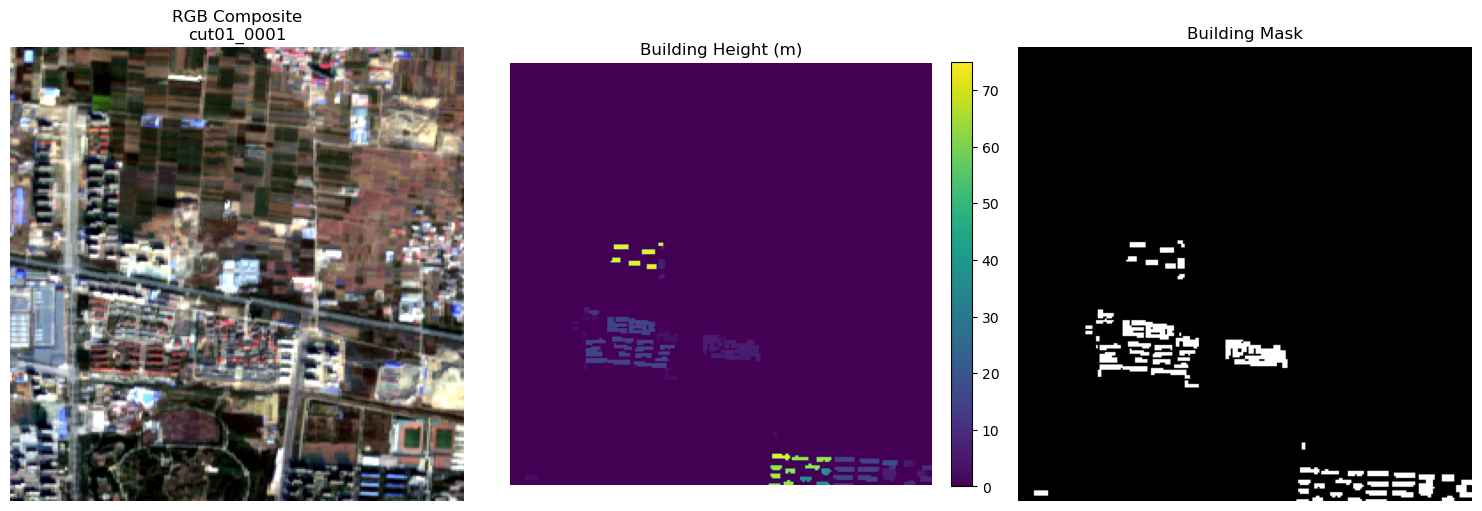


Sample Statistics for cut01_0001:
Height range: 0.0 - 75.0 m
Mean height: 0.6 m
Building coverage: 3.1%
Number of buildings: 56
Average building size: 35.8 pixels


In [127]:
# Test with a small sample first
def test_pipeline():
    """Test the pipeline with cut1 only."""
    print("Testing pipeline with cut1...")
    
    # Get tiles from cut1
    tile_ids = get_tile_ids(1)
    print(f"Found {len(tile_ids)} tiles in cut1: {tile_ids[:5]}...")
    
    if tile_ids:
        # Test with first tile
        result = process_single_tile(1, tile_ids[0])
        print(f"\nTest result for cut1, tile {tile_ids[0]}:")
        print(f"  RGB success: {result['rgb_success']}")
        print(f"  Height success: {result['height_success']}")
        print(f"  Mask success: {result['mask_success']}")
        if result['error']:
            print(f"  Error: {result['error']}")
        
        # Verify the created files
        sample_verification()
    else:
        print("No tiles found in cut1!")

# Uncomment to test the pipeline
print("Ready to test! Uncomment 'test_pipeline()' to run a quick test.")
test_pipeline()

## 🚀 Start Full Processing

**Instructions:**
1. First run `test_pipeline()` above to verify everything works with a sample
2. If the test is successful, uncomment and run the cell below to process all cuts
3. The processing may take several hours depending on your system and dataset size
4. Monitor progress through the progress bars and output messages

**Expected Outputs:**
- `preprocessed/rgb/`: RGB composite images (3-band GeoTIFF)
- `preprocessed/height/`: Building height rasters (single-band float)  
- `preprocessed/mask/`: Binary building masks (single-band uint8)

**File Naming Convention:**
- `cut{XX}_{tile_id}.tif` in rgb/ folder (e.g., cut01_0001.tif)
- `cut{XX}_{tile_id}.tif` in height/ folder (e.g., cut01_0001.tif)
- `cut{XX}_{tile_id}.tif` in mask/ folder (e.g., cut01_0001.tif)

Starting processing of 67 cuts...
Height threshold: 0m
Minimum building size: 1 pixels
------------------------------------------------------------


Processing cuts:   1%|▏         | 1/67 [00:01<01:32,  1.41s/it]

Cut  1: 23 tiles | RGB: 23/23 | Height: 23/23 | Mask: 23/23


Processing cuts:   3%|▎         | 2/67 [00:13<08:33,  7.89s/it]

Cut  2: 190 tiles | RGB: 190/190 | Height: 190/190 | Mask: 190/190


Processing cuts:   4%|▍         | 3/67 [00:20<07:38,  7.16s/it]

Cut  3: 103 tiles | RGB: 103/103 | Height: 103/103 | Mask: 103/103


Processing cuts:   6%|▌         | 4/67 [00:26<07:04,  6.74s/it]

Cut  4: 98 tiles | RGB: 98/98 | Height: 98/98 | Mask: 98/98


Processing cuts:   7%|▋         | 5/67 [00:30<05:52,  5.69s/it]

Cut  5: 72 tiles | RGB: 72/72 | Height: 72/72 | Mask: 72/72


Processing cuts:   9%|▉         | 6/67 [00:47<09:53,  9.73s/it]

Cut  6: 277 tiles | RGB: 277/277 | Height: 277/277 | Mask: 277/277


Processing cuts:  10%|█         | 7/67 [00:54<08:38,  8.64s/it]

Cut  7: 103 tiles | RGB: 103/103 | Height: 103/103 | Mask: 103/103


Processing cuts:  12%|█▏        | 8/67 [00:56<06:41,  6.81s/it]

Cut  8: 49 tiles | RGB: 49/49 | Height: 49/49 | Mask: 49/49


Processing cuts:  13%|█▎        | 9/67 [01:02<06:17,  6.52s/it]

Cut  9: 98 tiles | RGB: 98/98 | Height: 98/98 | Mask: 98/98


Processing cuts:  15%|█▍        | 10/67 [01:03<04:28,  4.72s/it]

Cut 10: 11 tiles | RGB: 11/11 | Height: 11/11 | Mask: 11/11


Processing cuts:  16%|█▋        | 11/67 [01:13<05:52,  6.29s/it]

Cut 11: 150 tiles | RGB: 150/150 | Height: 150/150 | Mask: 150/150


Processing cuts:  18%|█▊        | 12/67 [01:15<04:39,  5.08s/it]

Cut 12: 37 tiles | RGB: 37/37 | Height: 37/37 | Mask: 37/37


Processing cuts:  19%|█▉        | 13/67 [01:18<04:03,  4.52s/it]

Cut 13: 54 tiles | RGB: 54/54 | Height: 54/54 | Mask: 54/54


Processing cuts:  21%|██        | 14/67 [01:23<04:04,  4.62s/it]

Cut 14: 76 tiles | RGB: 76/76 | Height: 76/76 | Mask: 76/76


Processing cuts:  22%|██▏       | 15/67 [01:24<03:05,  3.57s/it]

Cut 15: 20 tiles | RGB: 20/20 | Height: 20/20 | Mask: 20/20


Processing cuts:  24%|██▍       | 16/67 [01:32<04:05,  4.81s/it]

Cut 16: 124 tiles | RGB: 124/124 | Height: 124/124 | Mask: 124/124


Processing cuts:  25%|██▌       | 17/67 [01:38<04:17,  5.16s/it]

Cut 17: 91 tiles | RGB: 91/91 | Height: 91/91 | Mask: 91/91


Processing cuts:  27%|██▋       | 18/67 [01:40<03:27,  4.24s/it]

Cut 18: 31 tiles | RGB: 31/31 | Height: 31/31 | Mask: 31/31


Processing cuts:  28%|██▊       | 19/67 [01:41<02:33,  3.19s/it]

Cut 19: 14 tiles | RGB: 14/14 | Height: 14/14 | Mask: 14/14


Processing cuts:  30%|██▉       | 20/67 [01:42<02:03,  2.63s/it]

Cut 20: 22 tiles | RGB: 22/22 | Height: 22/22 | Mask: 22/22


Processing cuts:  31%|███▏      | 21/67 [01:44<01:53,  2.47s/it]

Cut 21: 36 tiles | RGB: 36/36 | Height: 36/36 | Mask: 36/36


Processing cuts:  33%|███▎      | 22/67 [01:49<02:24,  3.21s/it]

Cut 22: 79 tiles | RGB: 79/79 | Height: 79/79 | Mask: 79/79


Processing cuts:  34%|███▍      | 23/67 [01:50<01:55,  2.61s/it]

Cut 23: 20 tiles | RGB: 20/20 | Height: 20/20 | Mask: 20/20


Processing cuts:  36%|███▌      | 24/67 [02:12<06:00,  8.38s/it]

Cut 24: 342 tiles | RGB: 342/342 | Height: 342/342 | Mask: 342/342


Processing cuts:  37%|███▋      | 25/67 [02:14<04:27,  6.37s/it]

Cut 25: 27 tiles | RGB: 27/27 | Height: 27/27 | Mask: 27/27


Processing cuts:  39%|███▉      | 26/67 [02:14<03:07,  4.58s/it]

Cut 26:  7 tiles | RGB:  7/7 | Height:  7/7 | Mask:  7/7


Processing cuts:  40%|████      | 27/67 [02:16<02:27,  3.69s/it]

Cut 27: 27 tiles | RGB: 27/27 | Height: 27/27 | Mask: 27/27


Processing cuts:  42%|████▏     | 28/67 [02:16<01:43,  2.65s/it]

Cut 28:  3 tiles | RGB:  3/3 | Height:  3/3 | Mask:  3/3


Processing cuts:  43%|████▎     | 29/67 [02:18<01:33,  2.46s/it]

Cut 29: 35 tiles | RGB: 35/35 | Height: 35/35 | Mask: 35/35


Processing cuts:  45%|████▍     | 30/67 [02:26<02:29,  4.03s/it]

Cut 30: 128 tiles | RGB: 128/128 | Height: 128/128 | Mask: 128/128


Processing cuts:  46%|████▋     | 31/67 [02:30<02:22,  3.95s/it]

Cut 31: 62 tiles | RGB: 62/62 | Height: 62/62 | Mask: 62/62


Processing cuts:  48%|████▊     | 32/67 [02:40<03:27,  5.94s/it]

Cut 32: 176 tiles | RGB: 176/176 | Height: 176/176 | Mask: 176/176


Processing cuts:  49%|████▉     | 33/67 [02:45<03:08,  5.54s/it]

Cut 33: 74 tiles | RGB: 74/74 | Height: 74/74 | Mask: 74/74


Processing cuts:  51%|█████     | 34/67 [02:51<03:11,  5.80s/it]

Cut 34: 104 tiles | RGB: 104/104 | Height: 104/104 | Mask: 104/104


Processing cuts:  52%|█████▏    | 35/67 [02:54<02:33,  4.79s/it]

Cut 35: 38 tiles | RGB: 38/38 | Height: 38/38 | Mask: 38/38


Processing cuts:  54%|█████▎    | 36/67 [02:55<01:59,  3.87s/it]

Cut 36: 29 tiles | RGB: 29/29 | Height: 29/29 | Mask: 29/29


Processing cuts:  55%|█████▌    | 37/67 [03:04<02:40,  5.36s/it]

Cut 37: 147 tiles | RGB: 147/147 | Height: 147/147 | Mask: 147/147


Processing cuts:  57%|█████▋    | 38/67 [03:05<01:57,  4.06s/it]

Cut 38: 20 tiles | RGB: 20/20 | Height: 20/20 | Mask: 20/20


Processing cuts:  58%|█████▊    | 39/67 [03:07<01:36,  3.45s/it]

Cut 39: 33 tiles | RGB: 33/33 | Height: 33/33 | Mask: 33/33


Processing cuts:  60%|█████▉    | 40/67 [03:17<02:24,  5.35s/it]

Cut 40: 165 tiles | RGB: 165/165 | Height: 165/165 | Mask: 165/165


Processing cuts:  61%|██████    | 41/67 [03:24<02:30,  5.78s/it]

Cut 41: 113 tiles | RGB: 113/113 | Height: 113/113 | Mask: 113/113


Processing cuts:  63%|██████▎   | 42/67 [03:28<02:13,  5.34s/it]

Cut 42: 76 tiles | RGB: 76/76 | Height: 76/76 | Mask: 76/76


Processing cuts:  64%|██████▍   | 43/67 [03:34<02:14,  5.61s/it]

Cut 43: 103 tiles | RGB: 103/103 | Height: 103/103 | Mask: 103/103


Processing cuts:  66%|██████▌   | 44/67 [03:37<01:45,  4.59s/it]

Cut 44: 40 tiles | RGB: 40/40 | Height: 40/40 | Mask: 40/40


Processing cuts:  67%|██████▋   | 45/67 [03:38<01:22,  3.74s/it]

Cut 45: 26 tiles | RGB: 26/26 | Height: 26/26 | Mask: 26/26


Processing cuts:  69%|██████▊   | 46/67 [03:40<01:08,  3.25s/it]

Cut 46: 35 tiles | RGB: 35/35 | Height: 35/35 | Mask: 35/35


Processing cuts:  70%|███████   | 47/67 [03:46<01:19,  3.98s/it]

Cut 47: 96 tiles | RGB: 96/96 | Height: 96/96 | Mask: 96/96


Processing cuts:  72%|███████▏  | 48/67 [03:49<01:10,  3.70s/it]

Cut 48: 51 tiles | RGB: 51/51 | Height: 51/51 | Mask: 51/51


Processing cuts:  73%|███████▎  | 49/67 [04:03<02:00,  6.68s/it]

Cut 49: 225 tiles | RGB: 225/225 | Height: 225/225 | Mask: 225/225


Processing cuts:  75%|███████▍  | 50/67 [04:04<01:27,  5.14s/it]

Cut 50: 29 tiles | RGB: 29/29 | Height: 29/29 | Mask: 29/29


Processing cuts:  76%|███████▌  | 51/67 [04:09<01:19,  5.00s/it]

Cut 51: 79 tiles | RGB: 79/79 | Height: 79/79 | Mask: 79/79


Processing cuts:  78%|███████▊  | 52/67 [04:13<01:08,  4.59s/it]

Cut 52: 62 tiles | RGB: 62/62 | Height: 62/62 | Mask: 62/62


Processing cuts:  79%|███████▉  | 53/67 [04:25<01:35,  6.79s/it]

Cut 53: 199 tiles | RGB: 199/199 | Height: 199/199 | Mask: 199/199


Processing cuts:  81%|████████  | 54/67 [04:26<01:05,  5.06s/it]

Cut 54: 16 tiles | RGB: 16/16 | Height: 16/16 | Mask: 16/16


Processing cuts:  82%|████████▏ | 55/67 [04:28<00:49,  4.14s/it]

Cut 55: 33 tiles | RGB: 33/33 | Height: 33/33 | Mask: 33/33


Processing cuts:  84%|████████▎ | 56/67 [04:29<00:34,  3.15s/it]

Cut 56: 13 tiles | RGB: 13/13 | Height: 13/13 | Mask: 13/13


Processing cuts:  85%|████████▌ | 57/67 [04:32<00:33,  3.31s/it]

Cut 57: 65 tiles | RGB: 65/65 | Height: 65/65 | Mask: 65/65


Processing cuts:  87%|████████▋ | 58/67 [04:33<00:22,  2.52s/it]

Cut 58: 12 tiles | RGB: 12/12 | Height: 12/12 | Mask: 12/12


Processing cuts:  88%|████████▊ | 59/67 [04:43<00:37,  4.73s/it]

Cut 59: 165 tiles | RGB: 165/165 | Height: 165/165 | Mask: 165/165


Processing cuts:  90%|████████▉ | 60/67 [04:44<00:25,  3.64s/it]

Cut 60: 19 tiles | RGB: 19/19 | Height: 19/19 | Mask: 19/19


Processing cuts:  91%|█████████ | 61/67 [04:45<00:17,  2.95s/it]

Cut 61: 20 tiles | RGB: 20/20 | Height: 20/20 | Mask: 20/20


Processing cuts:  93%|█████████▎| 62/67 [05:24<01:09, 13.81s/it]

Cut 62: 640 tiles | RGB: 640/640 | Height: 640/640 | Mask: 640/640


Processing cuts:  94%|█████████▍| 63/67 [05:26<00:40, 10.11s/it]

Cut 63: 27 tiles | RGB: 27/27 | Height: 27/27 | Mask: 27/27


Processing cuts:  96%|█████████▌| 64/67 [05:26<00:21,  7.24s/it]

Cut 64: 11 tiles | RGB: 11/11 | Height: 11/11 | Mask: 11/11


Processing cuts:  97%|█████████▋| 65/67 [05:29<00:11,  5.96s/it]

Cut 65: 53 tiles | RGB: 53/53 | Height: 53/53 | Mask: 53/53


Processing cuts:  99%|█████████▊| 66/67 [05:34<00:05,  5.48s/it]

Cut 66: 76 tiles | RGB: 76/76 | Height: 76/76 | Mask: 76/76


Processing cuts: 100%|██████████| 67/67 [05:41<00:00,  5.09s/it]



Cut 67: 127 tiles | RGB: 127/127 | Height: 127/127 | Mask: 127/127

PROCESSING COMPLETE
Total tiles processed: 5606
RGB composites created: 5606 (100.0%)
Height rasters copied: 5606 (100.0%)
Building masks created: 5606 (100.0%)
Checking preprocessed data...
Files found:
  RGB: 5606 files
  HEIGHT: 5606 files
  MASK: 5606 files

Visualizing samples...
Files found:
  RGB: 5606 files
  HEIGHT: 5606 files
  MASK: 5606 files

Visualizing samples...


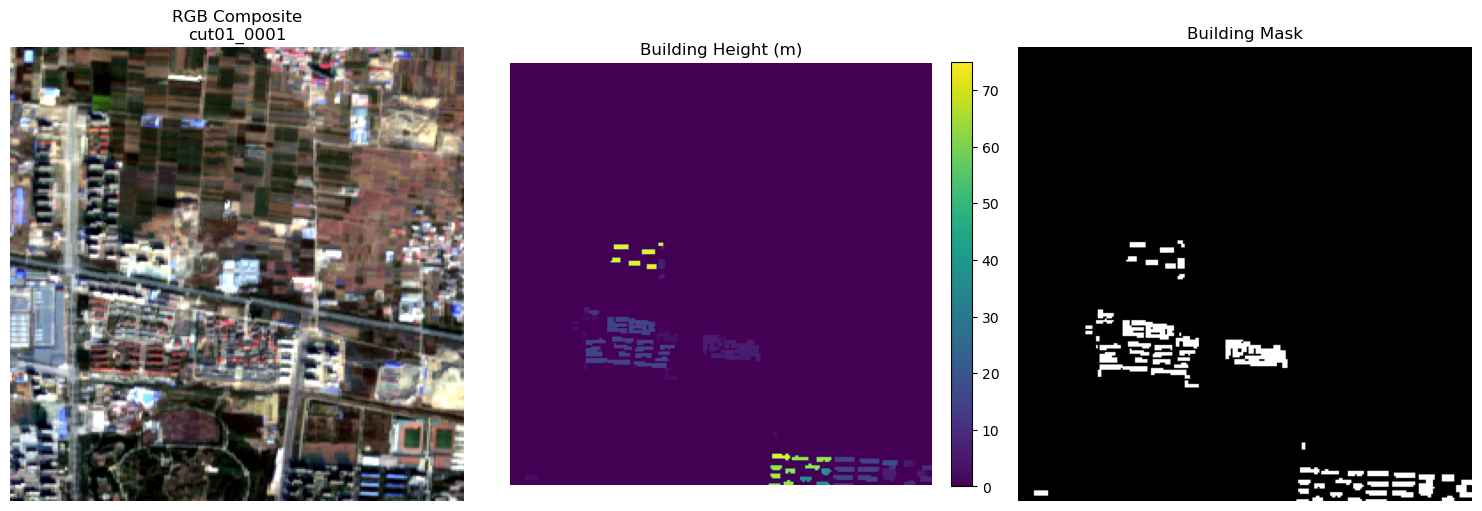


Sample Statistics for cut01_0001:
Height range: 0.0 - 75.0 m
Mean height: 0.6 m
Building coverage: 3.1%
Number of buildings: 56
Average building size: 35.8 pixels


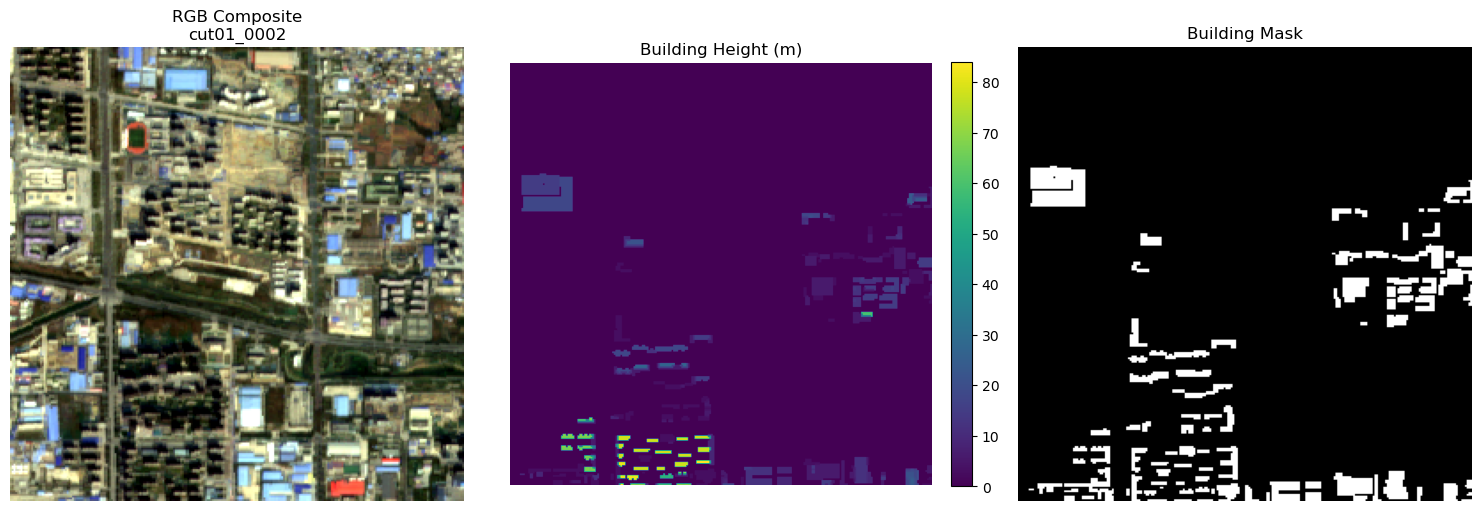


Sample Statistics for cut01_0002:
Height range: 0.0 - 84.0 m
Mean height: 1.2 m
Building coverage: 7.3%
Number of buildings: 89
Average building size: 53.6 pixels


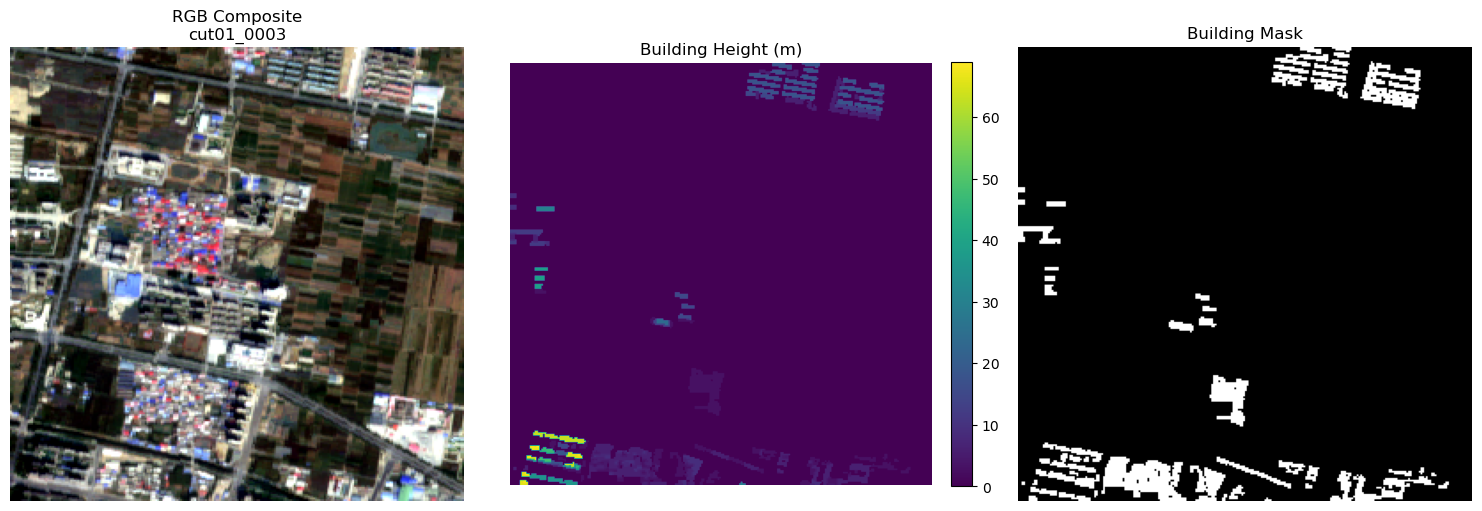


Sample Statistics for cut01_0003:
Height range: 0.0 - 69.0 m
Mean height: 0.7 m
Building coverage: 6.0%
Number of buildings: 49
Average building size: 79.7 pixels
Full processing ready!

📝 INSTRUCTIONS:
1. First test with: test_pipeline()
2. If successful, uncomment the processing_results line above
3. Run sample_verification() to check results
4. Processing time estimate: 2-4 hours for full dataset


In [128]:
# 🚀 FULL PROCESSING - Uncomment to run on all cuts
# This will process all 67 cuts and may take several hours

processing_results = process_all_cuts()

# After processing completes, run verification
sample_verification()

print("Full processing ready!")
print("\n📝 INSTRUCTIONS:")
print("1. First test with: test_pipeline()")
print("2. If successful, uncomment the processing_results line above")
print("3. Run sample_verification() to check results")
print("4. Processing time estimate: 2-4 hours for full dataset")